# A tiny model to explain the QML principles using PennyLane

_This notebook explores the creation and use of a very simple model in **PennyLane and PyTorch**_.

**By:** Jacob Cybulski ([website](https://jacobcybulski.com/))<br>
**Date:** March 26, 2025<br>
**Updates:** September 21, 2025<br>
**Aims:** To develop a tiny quantum model in PennyLane to explain QML principles<br/>
**Prerequisites:** We will assume your knowledge of *quantum computing*, *machine learning* and *Python*<br>
**License:** 
This project is licensed under the [GPL-3.0](https://www.gnu.org/licenses/gpl-3.0.txt)<br>
**Changes:** All changes to this code must be listed at the bottom of this notebook

## Libraries

In [1]:
import sys
sys.path.append('.')
sys.path.append('..')
sys.path

['/home/jacob/miniconda3/envs/pl-42/lib/python311.zip',
 '/home/jacob/miniconda3/envs/pl-42/lib/python3.11',
 '/home/jacob/miniconda3/envs/pl-42/lib/python3.11/lib-dynload',
 '',
 '/home/jacob/miniconda3/envs/pl-42/lib/python3.11/site-packages',
 '.',
 '..']

In [2]:
### General libraries

import matplotlib.pyplot as plt
from matplotlib import set_loglevel
set_loglevel("warning")

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [3]:
### Import utilities
#   Examples of charts from this library will be presented here

from utilities import *

In [4]:
### PennyLane and Torch

import pennylane as qml
from pennylane import numpy as np
from pennylane import NesterovMomentumOptimizer
from torch import nn
from torch.autograd import Variable
import torch

## Explore a PennyLane tiny quantum model

We will first identify what quantum devices and gradient support we have, then we will show the principles of working with PennyLane, then prepare data for model training and testing, create a quantum model, and finally train it and test it.

### Define device to compute on
*We have a variety of different types of quantum devices.*
- **default.qubit:** used for state vector simulations
- **lightning.qubit:** high performance qubit (written in C++)
- **lightning.gpu:** a GPU state vector qubit simulation (NVIDIA)
- **default.tensor:** a state vector simulator based on tensor networks
- **qiskit.remote:** a Qiskit device accessible via *qiskit_ibm_runtime* interface
- **default.mixed:** a mixed state simulator of Qiskit based quantum circuits
- *And many more (over 40 different devices)*

In [5]:
### Select a device for PL operation

# Quantum simulator
sim = 'default.qubit'

### Show QML principles with PennyLane

### Set up our data
*Note that weights require gradients and inputs are just plain values.*

In [6]:
### Test data
#   Note that 'np' is from PennyLane, so it is automatically a tensor!
#   However, it is always better to explicitly convert Numpy array to tensors

inputs = np.array([np.pi*0.7, np.pi/4], requires_grad=False)   # Plain values
weights = np.array([1.7, 0.5, 0.5], requires_grad=True)        # Parameters with gradients

### This is our data
inputs

tensor([2.19911486, 0.78539816], requires_grad=False)

In [7]:
weights

tensor([1.7, 0.5, 0.5], requires_grad=True)

### Define a circuit

In [8]:
### Simple circuit creation and execution
dev1 = qml.device(sim, wires=2, shots=1000)

@qml.qnode(dev1)
def circuit1(inputs, weights):
    
    # Feature map
    qml.RY(inputs[0], wires=0)
    qml.RY(inputs[1], wires=1)
    qml.Barrier()

    # Ansatz
    qml.RX(weights[0], wires=0)
    qml.RY(weights[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(weights[2], wires=1)
    qml.Barrier()

    # Measurement
    return qml.probs(wires=range(2))

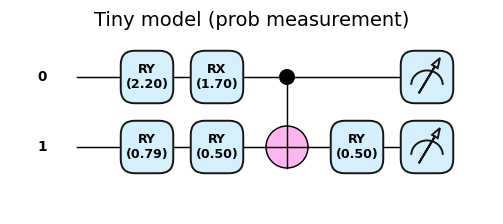

In [9]:
### Plot the circuit
draw_circuit(circuit1, scale=0.7, title='Tiny model (prob measurement)', style='pennylane')(inputs, weights)

#### Apply the circuit to some data and see the results

In [10]:
### Run the circuit
results1 = circuit1(inputs, weights)
results1

array([0.219, 0.351, 0.07 , 0.36 ])

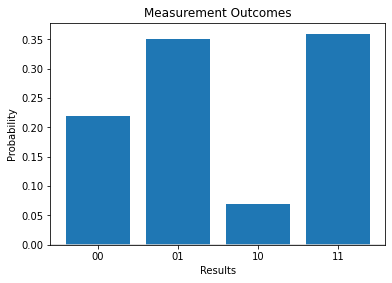

In [11]:
### Plot the results
plot_hist(results1, figsize=(6, 4), title='Measurement Outcomes')

#### Explore the gradients of this circuit
*In the following example we will see the gradients of this circuit given as a Jacobian matrix:*
$$
\mathbf{J} = 
\begin{pmatrix}
 \frac{\partial P_{00}}{\partial w_0} & \frac{\partial P_{00}}{\partial w_1} & \frac{\partial P_{00}}{\partial w_2} \\
 \frac{\partial P_{01}}{\partial w_0} & \frac{\partial P_{01}}{\partial w_1} & \frac{\partial P_{01}}{\partial w_2} \\
 \frac{\partial P_{10}}{\partial w_0} & \frac{\partial P_{10}}{\partial w_1} & \frac{\partial P_{10}}{\partial w_2} \\
 \frac{\partial P_{11}}{\partial w_0} & \frac{\partial P_{11}}{\partial w_1} & \frac{\partial P_{11}}{\partial w_2}
\end{pmatrix}
$$
where $P_{ij}$ is the probability of measuring the state $\vert ij \rangle$ and $w_k$ is the k-th weight.<br>
Each of the terms in the Jacobian is calculated from the parameter-shift rule (let's use $P_{00}$ as an example):
$$
\frac{\partial P_{00}}{\partial w_0} \approx \frac{1}{2} \left[ P_{00}\left(w_0 + \frac{\pi}{2}, w_1, w_2\right) - P_{00}\left(w_0 - \frac{\pi}{2}, w_1, w_2\right) \right]
$$
and here:
- $\frac{\partial P_{00}}{\partial w_0}$ is the partial derivative of the probability of measuring state $\vert 00 \rangle$ with respect to the first weight, $w_0$.
- $P_{00}\left(w_0 + \frac{\pi}{2}, \dots\right)$ is the estimated probability of measuring $\vert 00 \rangle$ after running the circuit with the first weight shifted forward by $\pi / 2$.
- $P_{00}\left(w_0 - \frac{\pi}{2}, \dots\right)$ is the estimated probability of measuring $\vert 00 \rangle$ after running the circuit with the first weight shifted backward $\pi / 2$.
- Only probability $P_{00}$ and weight $w_0$ are being affected, while the remaining probabilities and weights remain unchanged.
- THe offset $\pi/2$ has been selected to leverage the trigonometric nature of quantum gates to arrive at a true derivative $\frac{\partial P_{00}}{\partial w_0}$.

In [12]:
### Show the Jacobian matrix J(i, j) for the circuit weights
qml.gradients.param_shift(circuit1)(inputs, weights)

array([[ 0.1115, -0.2625, -0.264 ],
       [ 0.177 ,  0.2585,  0.2625],
       [-0.032 ,  0.1595, -0.158 ],
       [-0.2565, -0.1555,  0.1595]])

*These gradients can be used by optimisers to find the optimum weights (with respect of a data sample) for the circuit.*<br>
__*We will later show you how to do this!*__

#### Let's run this circuit a few times
*Observe results, why do you think we get different results each time?*

In [13]:
results2 = circuit1(inputs, weights)
results2

array([0.207, 0.325, 0.083, 0.385])

In [14]:
results3 = circuit1(inputs, weights)
results3

array([0.22 , 0.337, 0.082, 0.361])

#### Now let's pass multiple inputs to the circuit
*__Warning:__ if applying the circuit to multiple inputs is confusing, just do it in a loop one input at a time.*<br> 
*Note that the result is produced in the form to support PennyLane gradient calculations.*<br>
*However, this format is not compatible with what we are used to in other ML packages.*

In [15]:
### Prepare a tensor of multiple inputs
multi_inputs = np.stack([inputs, inputs, inputs, inputs, inputs])
multi_inputs

tensor([[2.19911486, 0.78539816],
        [2.19911486, 0.78539816],
        [2.19911486, 0.78539816],
        [2.19911486, 0.78539816],
        [2.19911486, 0.78539816]], requires_grad=False)

In [16]:
### Get the results
results4 = circuit1(multi_inputs, weights)
results4

array([[0.   , 0.539, 0.368, 0.093],
       [0.192, 0.266, 0.069, 0.473]])

__*What happened here?*__<br>
*We expect the circuit to be called $n$ times and return $n$ sets of 4 measurement outcomes each.<br>
However, PL uses "parameter broadcasting", where the qnode code is run once only!<br>
The first objective of this run is to create the circuit's abstract representation, called quantum tape.<br>
The second objective is to create a tensor of values to be assigned to each parameter!<br>
Each tensor must be of the same size, which is called the batch size.<br>
Then, PL will assign values to each parameter and execute the circuit the batch size times.<br>
So, consider what is inputs[0] and inputs[1] in the previous case, how many results will be produced?<br> 
How should the circuit be changed, to provide $n$ correct values to each input parameter?*

In [17]:
### Another version of the circuit for batched inputs
@qml.qnode(dev1)
def circuit1_batched(inputs, weights):
    # Parameter inputs is now a batched tensor of shape (n, 2)
    
    # Apply the first feature of all n inputs to wire 0
    qml.RY(inputs[:, 0], wires=0)
    
    # Apply the second feature of all n inputs to wire 1
    qml.RY(inputs[:, 1], wires=1)

    qml.Barrier()

    # Ansatz (weights are automatically broadcast to match the input batch size)
    qml.RX(weights[0], wires=0)
    qml.RY(weights[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(weights[2], wires=1)
    qml.Barrier()

    # Measurement
    return qml.probs(wires=range(2))

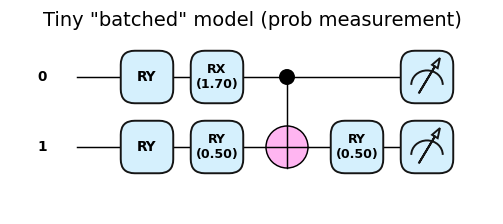

In [18]:
### Plot the circuit
draw_circuit(circuit1_batched, scale=0.7, title='Tiny "batched" model (prob measurement)', style='pennylane')(multi_inputs, weights)

In [19]:
### Get the results
results5 = circuit1_batched(multi_inputs, weights)
results5

array([[0.217, 0.318, 0.073, 0.392],
       [0.219, 0.325, 0.055, 0.401],
       [0.232, 0.319, 0.067, 0.382],
       [0.208, 0.335, 0.075, 0.382],
       [0.228, 0.331, 0.063, 0.378]])

__*This is now what we expected to get!*__

### The same circuit but measured differently
*Expvals are weighted averages of *eigenvalues* of an operator.*<br>
*For a single qubit, possible measurements for $\vert 0 \rangle$ is $+1$ and for $\vert 1 \rangle$ is $-1$.*<br>
*Depending on the circuit state, repeated measurements the result will reflect its bias.*

In [20]:
### Simple circuit creation and execution
dev2 = qml.device(sim, wires=2, shots=1000)

@qml.qnode(dev2)
def circuit2(inputs, weights):
    
    # Feature map
    qml.RY(inputs[0], wires=0)
    qml.RY(inputs[1], wires=1)
    qml.Barrier()

    # Ansatz
    qml.RX(weights[0], wires=0)
    qml.RY(weights[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(weights[2], wires=1)
    qml.Barrier()

    # Measurement
    return [qml.expval(qml.PauliZ(m)) for m in range(2)]

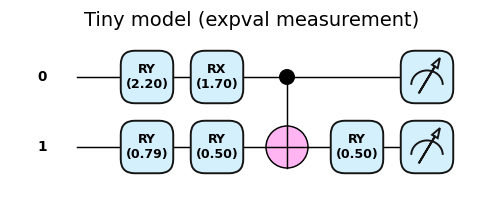

In [21]:
### Plot the circuit
draw_circuit(circuit2, scale=0.7, title='Tiny model (expval measurement)', style='pennylane')(inputs, weights)

__*This circuit "looks" the same but it has a very different behaviour!*__

#### Run the circuit

In [22]:
results6 = circuit2(inputs, weights)
results6

[array(0.07), array(-0.394)]

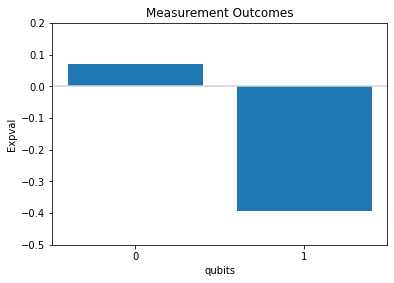

In [23]:
### Plot the results
plot_hist(results6, figsize=(6, 4), labels=['0', '1'], ylim=(-0.5, 0.2), 
          xlabel='qubits', ylabel='Expval', title='Measurement Outcomes')

In [24]:
### Show gradients at each of the model parameters
qml.gradients.param_shift(circuit2)(inputs, weights)

[array([ 0.624, -0.012,  0.016]), array([ 0.187, -0.169, -0.854])]

#### Investigate a batched version of this circuit

In [25]:
### Try a batched version of this circuit
@qml.qnode(dev2)
def circuit2_batched(inputs, weights):
    
    # Feature map
    qml.RY(inputs[:, 0], wires=0)
    qml.RY(inputs[:, 1], wires=1)
    qml.Barrier()

    # Ansatz
    qml.RX(weights[0], wires=0)
    qml.RY(weights[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(weights[2], wires=1)
    qml.Barrier()

    # Measurement
    return [qml.expval(qml.PauliZ(m)) for m in range(2)]

results7 = circuit2_batched(multi_inputs, weights)
results7

[array([0.09 , 0.024, 0.074, 0.104, 0.048]),
 array([-0.404, -0.452, -0.464, -0.426, -0.412])]

__*What happened here?*__<br>
*In the previous case, we measured probability, which was a single outcome of multiple values.*<br>
*This time, we measured expvals of each qubit, which is multiple outcomes of a single value.*<br>
*Therefore the result "seems" to be presented differently.*<br>
*To get an identical format of results, we will need to transpose it.*

In [26]:
### Because the circuit produced two different outcomes
#   they appeared differently and we need to transpose them
results8 = np.transpose(np.stack(results7)).numpy()
results8

array([[ 0.09 , -0.404],
       [ 0.024, -0.452],
       [ 0.074, -0.464],
       [ 0.104, -0.426],
       [ 0.048, -0.412]])

## What's next?
*At this point you can go to the more advanced QML models to learn how to optimise their parameters.*

## Modifications (do not remove)
Under the [Creative Commons CC-BY](https://creativecommons.org/licenses/by/4.0/) license, if you perform any changes to this notebook, please list them here, adding a note with your name, contact details, date and changes to the code.

- [Jacob Cybulski](http://jacobcybulski.com) (2024, 1 Oct): The author of this notebook added this section to record all code changes

## Systems in use (Linux)

In [27]:
!pip list | grep -e pennylane -e torch

pennylane                 0.42.3
pennylane_lightning       0.42.0
torch                     2.8.0
torchaudio                2.8.0
torcheval                 0.0.7
torchmetrics              1.8.2
torchsummary              1.5.1
torchvision               0.23.0
